In [1]:
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
from DifferentiableHOS.Fisher import fisher

In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=1/pix_scale

In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [4]:
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps2"):
        res2 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps2', filename), 'rb'))
        kmaps.append(res2['kmap'])

In [5]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)
def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10  # gal/arcmin **2
    pix_scale = field_size / field_npix * 60  # arcmin
    ngal_per_pix = ngal * pix_scale**2  # galaxies per pixels
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)  # Rescaled noise sigma
    sigma_pix = 1. / pix_scale  # Smooth at 1 arcmin
    # Add noise
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    # Add smoothing
    kmap = perf_smoothing(kmap)
    return kmap

In [6]:
kmaps_r=[]
for m in kmaps:
        m=desc_y1_analysis(m)
        kmaps_r.append(m)
        

In [7]:
ps_tot=[]
ps_tot_red=[]
for m in kmaps_r:
    ell, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
    # Keep only ell between 300 and 3000
    ell = ell[2:46]
    power_spectrum = power_spectrum[2:46]
    # Further reducing the nnumber of points
    ell = rebin(ell, 11)
    power_spectrum = rebin(power_spectrum, 11)
    ps_tot.append(power_spectrum)


In [9]:
ps_tot= stack(ps_tot, axis=0)

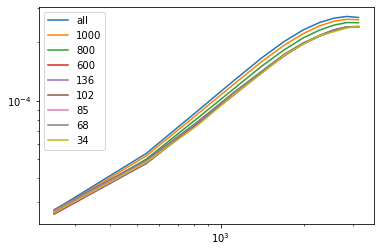

In [10]:
loglog(ell,ell*(ell+1)*ps_tot.mean(axis=0)/(2*np.pi),label='all')
loglog(ell,ell*(ell+1)*ps_tot[:1000].mean(axis=0)/(2*np.pi),label='1000')
loglog(ell,ell*(ell+1)*ps_tot[:800].mean(axis=0)/(2*np.pi),label='800')
loglog(ell,ell*(ell+1)*ps_tot[:600].mean(axis=0)/(2*np.pi),label='600')
loglog(ell,ell*(ell+1)*ps_tot[:136].mean(axis=0)/(2*np.pi),label='136')
loglog(ell,ell*(ell+1)*ps_tot[:102].mean(axis=0)/(2*np.pi),label='102')
loglog(ell,ell*(ell+1)*ps_tot[:85].mean(axis=0)/(2*np.pi),label='85')
loglog(ell,ell*(ell+1)*ps_tot[:68].mean(axis=0)/(2*np.pi),label='68')
loglog(ell,ell*(ell+1)*ps_tot[:34].mean(axis=0)/(2*np.pi),label='34')

legend()

In [11]:
import math
fov_rad=math.radians(5)
Omega_sky=pi*(fov_rad)**2#Omega_sky is defined as pi for my field ov view squared translated in radians
f_sky=Omega_sky/4/pi
cov_ps=np.cov(ps_tot, rowvar=False)*f_sky/0.25

In [12]:
cov_ps=np.cov(ps_tot, rowvar=False)*f_sky/0.25

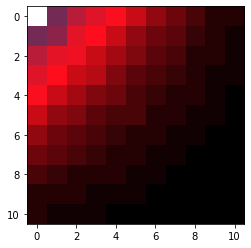

In [13]:
imshow(cov_ps,cmap='gist_stern')

In [ ]:
#np.save("ps.npy",ps_tot)

In [14]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
ps_jac_corner= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac2"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac2', filename), 'rb'))
        ps_jac_corner.append(res['jac_ps'])

In [15]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac3"):
        res2 =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac3', filename), 'rb'))
        ps_jac_corner.append(res2['jac_ps'])

In [16]:
ps_jac_corner = stack(ps_jac_corner, axis=0)

In [17]:
dmu_ps = ps_jac_corner.mean(axis=0)

In [18]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$"]

In [19]:
# The way to use this:
fid_cosmo = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0}

In [20]:
Fisher_ps=dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps

In [21]:
fisher_object_ps = fisher(Fisher_ps, labels,  fid_cosmo)

In [22]:
dmu_ps_136 = ps_jac_corner[:136].mean(axis=0)
Fisher_ps_136=dmu_ps_136.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_136
fisher_object_ps_136 = fisher(Fisher_ps_136, labels,  fid_cosmo)

In [23]:
dmu_ps_102 = ps_jac_corner[:102].mean(axis=0)
Fisher_ps_102=dmu_ps_102.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_102
fisher_object_ps_102 = fisher(Fisher_ps_102, labels,  fid_cosmo)

In [24]:
dmu_ps_85 = ps_jac_corner[:85].mean(axis=0)
Fisher_ps_85=dmu_ps_85.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_85
fisher_object_ps_85 = fisher(Fisher_ps_85, labels,  fid_cosmo)

In [25]:
dmu_ps_68 = ps_jac_corner[:68].mean(axis=0)
Fisher_ps_68=dmu_ps_68.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_68
fisher_object_ps_68 = fisher(Fisher_ps_68, labels,  fid_cosmo)

In [26]:
dmu_ps_34 = ps_jac_corner[:44].mean(axis=0)
Fisher_ps_34=dmu_ps_34.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_34
fisher_object_ps_34 = fisher(Fisher_ps_34, labels,  fid_cosmo)

/global/u1/d/dlan/DifferentiableHOS/DifferentiableHOS/Fisher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))


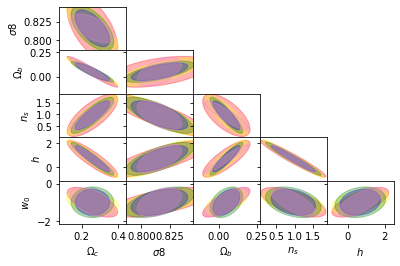

In [27]:
fisher_object_ps.corner_plot(color='red',alpha=0.3,label='all')
fisher_object_ps_136.corner_plot(color='yellow',alpha=1.3)
fisher_object_ps_102.corner_plot(color='green',alpha=1.3)
fisher_object_ps_85.corner_plot(color='blue',alpha=1.3)
fisher_object_ps_68.corner_plot(color='grey',alpha=1.3)
fisher_object_ps_34.corner_plot(color='violet',alpha=1.3)

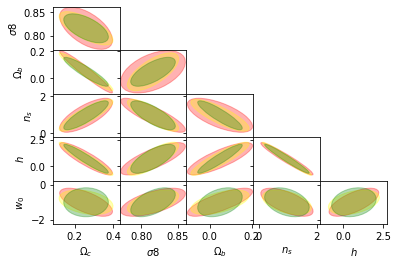

In [28]:
fisher_object_ps.corner_plot(color='red',alpha=0.3,label='all')
fisher_object_ps_136.corner_plot(color='yellow',alpha=1.3)
fisher_object_ps_102.corner_plot(color='green',alpha=1.3)

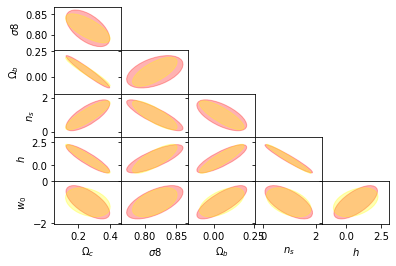

In [29]:
fisher_object_ps.corner_plot(color='red',alpha=0.3,label='all')
fisher_object_ps_136.corner_plot(color='yellow',alpha=1.3)